#1

In [1]:
from requests import get
import re
import string

In [2]:
urls = ['http://lib.ru/PROZA/LIMONOV/r_eastside.txt_Ascii.txt',
        'http://lib.ru/PROZA/LIMONOV/mussolini.txt_Ascii.txt',
        'http://lib.ru/PROZA/LIMONOV/r_editor.txt_Ascii.txt',
        'http://lib.ru/PROZA/LIMONOV/r_excesses.txt_Ascii.txt',
        'http://lib.ru/PROZA/LIMONOV/r_holiday.txt_Ascii.txt',
        'http://lib.ru/PROZA/LIMONOV/r_izya.txt_Ascii.txt',
        'https://lib.ru/PROZA/LIMONOV/r_leutenant.txt',
        'http://lib.ru/PROZA/LIMONOV/r_ship.txt_Ascii.txt',
        'http://lib.ru/PROZA/LIMONOV/r_those.txt_Ascii.txt',
        'http://lib.ru/PROZA/LIMONOV/r_twin.txt_Ascii.txt']

In [3]:
texts = [get(url).text.replace('\x14', ' ').replace('\x15', ' ') for url in urls]

In [4]:
!pip install pymorphy2 --q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 295.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 24.0 MB/s eta 0:00:00


In [5]:
!python -m spacy download ru_core_news_sm --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 32.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
!pip install jsonlines

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import time
import spacy
from spacy.lang.ru.examples import sentences
import jsonlines

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
nlp = spacy.load("ru_core_news_sm")

In [9]:
stops = stopwords.words("russian")

tfidf = TfidfVectorizer(
    analyzer="word", # анализировать по словам или по символам (char)
    stop_words=stops # передаём список стоп-слов для русского из NLTK
)

In [10]:
morph = MorphAnalyzer()

In [11]:
texts_preprocessed = ''
for a_text in texts:
    a_tokens = wordpunct_tokenize(a_text)
    a_lemmatized = " ".join([morph.parse(item)[0].normal_form for item in a_tokens])
    texts_preprocessed += a_lemmatized + ' '

In [12]:
doc = nlp(texts_preprocessed)

In [13]:
sw = stopwords.words('russian')

In [14]:
sents_list = []
for sent in doc.sents:
    sentance = sent.text.translate(str.maketrans('', '', string.punctuation))
    sents_list.append(' '.join([w.lower() for w in sentance.split(' ') if w.lower() not in sw]))

In [15]:
with jsonlines.open('texts.jsonl', mode='w') as writer:
    writer.write_all(sents_list)

#2

In [16]:
texts_tfidf = tfidf.fit_transform(sents_list)
print(f"Матрица на {texts_tfidf.shape[0]} документов и {texts_tfidf.shape[1]} термов")

Матрица на 4222 документов и 7686 термов


In [17]:
import gensim
import logging
import urllib.request

import warnings
warnings.filterwarnings('ignore')

In [18]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [19]:
f = 'texts.jsonl'
data = gensim.models.word2vec.LineSentence(f)

In [20]:
%time model_texts = gensim.models.Word2Vec(data, vector_size=300, window=5, min_count=5, epochs=50)

CPU times: user 4.35 s, sys: 111 ms, total: 4.46 s
Wall time: 3.81 s


In [21]:
model_path = "model_texts.bin"

model_texts.wv.save_word2vec_format(model_path, binary=True)

In [22]:
print(len(model_texts.wv.key_to_index))

1291


1291 слово - это мало

In [23]:
love_sim = model_texts.wv.most_similar("любовь", topn=10)
love_sim

[('заплатить', 0.8927615284919739),
 ('настаивать', 0.8901990652084351),
 ('понимать', 0.8889467716217041),
 ('"понимать', 0.8867803812026978),
 ('"думать', 0.8824338316917419),
 ('никак', 0.8765752911567688),
 ('никакой', 0.8762735724449158),
 ('спокойно', 0.8761200308799744),
 ('сосед', 0.8753762245178223),
 ('особенный', 0.8745067119598389)]

Вообще неожиданный результат. Но если так подумать, предсказать для такого абстрактного понятия что-либо тяжело. А вот если это слово представить буквально, то очень логично 'заниматься'.

Синонимов/антонимов нет.

О языке это ничего не говорит. О корпусе - он немного пошлый.

In [24]:
god_sim = model_texts.wv.most_similar("бог", topn=10)
god_sim

[('нюхать', 0.9748967289924622),
 ('спокойно', 0.974023699760437),
 ('книжка', 0.9738854765892029),
 ('осторожно', 0.9730584025382996),
 ('столько', 0.9703806638717651),
 ('приезжать', 0.9678375720977783),
 ('позвонить', 0.9652625918388367),
 ('"посмотреть', 0.9624608159065247),
 ('стесняться', 0.9624598026275635),
 ('настаивать', 0.9615602493286133)]

Тоже неожиданный результат. Мб только 'книжка' как-то логично звучит (Библия = книжка про Бога). Мб острожно еще.

Синонимы/антонимы: осторожно/равнодушно, спокойно-равнодушно (ну так, с натяжкой).

О языке это ничего не говорит. О корпусе - тоже ничего, разве что есть какой-то Луис (мб Луис Бог).

In [25]:
pos_neg_sim = model_texts.wv.most_similar(positive=["хороший"], negative=["плохой"], topn=10)
pos_neg_sim

[('очень', 0.2681337594985962),
 ('жизнь', 0.21424096822738647),
 ('время', 0.1877531260251999),
 ('это', 0.1803121417760849),
 ('женщина', 0.15618836879730225),
 ('нью', 0.15421098470687866),
 ('некоторый', 0.15308520197868347),
 ('жить', 0.14978471398353577),
 ('история', 0.1470758467912674),
 ('знать', 0.146945983171463)]

Довольно логичные слова. Не оч только: нью, джуля.

Синонимы/антонимы: нет (мб нью/история, если хотите. но нью - это прилагательное вообще-то).

О языке это ничего не говорит. О корпусе - тоже ничего, разве что есть какая-то Джуля

In [26]:
urllib.request.urlretrieve('http://vectors.nlpl.eu/repository/20/180.zip', 'ruscorpora_upos_cbow_300_20_2019.zip')

('ruscorpora_upos_cbow_300_20_2019.zip',
 <http.client.HTTPMessage at 0x784f18812a10>)

In [27]:
import zipfile

src = 'ruscorpora_upos_cbow_300_20_2019.zip'

with zipfile.ZipFile(src, 'r') as zip_ref:
    zip_ref.extractall('.')

In [28]:
m = 'model.bin'
model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=True)

In [29]:
print(' '.join([el[0] for el in love_sim]))

заплатить настаивать понимать "понимать "думать никак никакой спокойно сосед особенный


In [30]:
love_sim_pos = 'настаивать_VERB понимать_VERB заниматься_VERB никак_PRON спокойно_ADV эпизод_NOUN сосед_NOUN объяснить_VERB спокойный_ADJ'
love_sim_pos = love_sim_pos.split()

In [31]:
print(' '.join([el[0] for el in god_sim]))

нюхать спокойно книжка осторожно столько приезжать позвонить "посмотреть стесняться настаивать


In [32]:
god_sim_pos = 'осторожно_ADV нюхать_VERB книжка_NOUN равнодушно_ADV столько_PRON позвонить_VERB спокойно_ADV стесняться_VERB луис_NOUN приезжать_VERB'
god_sim_pos = god_sim_pos.split()


In [33]:
print(' '.join([el[0] for el in pos_neg_sim]))

очень жизнь время это женщина нью некоторый жить история знать


In [34]:
pos_neg_sim_pos = 'очень_ADV жить_VERB жизнь_NOUN нью_ADJ время_NOUN это_PRON джуля_NOUN йорк_NOUN история_NOUN некоторый_PRON'
pos_neg_sim_pos = pos_neg_sim_pos.split()

In [35]:
print(model.doesnt_match(love_sim_pos))

эпизод_NOUN


In [36]:
print(model.doesnt_match(god_sim_pos))

книжка_NOUN


In [37]:
print(model.doesnt_match(pos_neg_sim_pos))

очень_ADV


Я вообще по-другому думаю насчет последних двух. Ну типа с эпизодом окей, т.к. там все стремное. А вот книжка и очень - соотвественно буквально лучше всего подходят.

#3

##3.1

In [38]:
urllib.request.urlretrieve('http://vectors.nlpl.eu/repository/20/195.zip', '195.zip')

('195.zip', <http.client.HTTPMessage at 0x784e37d16ad0>)

In [39]:
import zipfile

src = '195.zip'

with zipfile.ZipFile(src, 'r') as zip_ref:
    zip_ref.extractall('.')

In [40]:
m_3 = 'model_3.bin'
model_3 = gensim.models.KeyedVectors.load_word2vec_format(m, binary=True)

In [51]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
import numpy as np
import math
from typing import List

In [102]:
word_seq = ['машина_NOUN', 'колесо_NOUN', 'крыло_NOUN', 'самолет_NOUN'] # машина - колесо + крыло = самолет

In [91]:
X = model_3[word_seq]

In [92]:
pca = PCA(n_components=2)
coords = pca.fit_transform(X)

In [99]:
def return_new_coords(coords: List[List[int]]) -> List[int]:
    return [
        -1 * (coords[0][0] + coords[1][0] + coords[2][0]),
        -1 * (coords[0][1] + coords[1][1] + coords[2][1])
    ]

In [101]:
model_3.most_similar(pca.inverse_transform(return_new_coords(coords)), topn=5)

[('самолет_NOUN', 0.9718787670135498),
 ('вертолет_NOUN', 0.8360581398010254),
 ('самолет_PROPN', 0.7850913405418396),
 ('бомбардировщик_NOUN', 0.7528537511825562),
 ('истребитель_NOUN', 0.7259307503700256)]

а ой, была функция такая. я проглядел. ну крч снизу по-нормальному

In [107]:
print(model_3.most_similar(positive=['машина_NOUN', 'крыло_NOUN'], negative=['колесо_NOUN'])[0][0])

самолет_NOUN


на правду похоже, одобряю

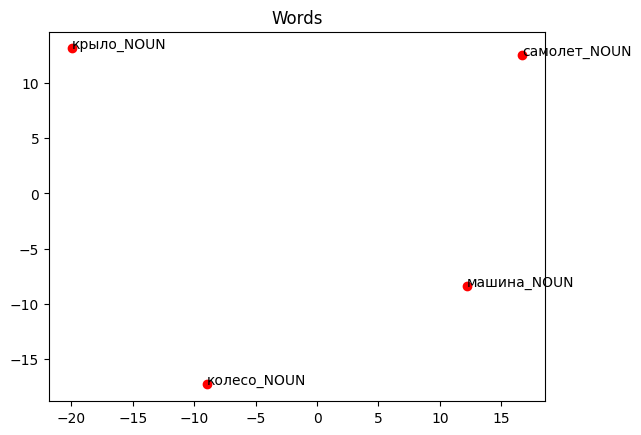

In [106]:
plt.scatter(coords[:, 0], coords[:, 1], color='red')
plt.title('Words')

for i, word in enumerate(word_seq):
    plt.annotate(word, xy=(coords[i, 0], coords[i, 1]))
plt.show()

Не похоже на правду :sob:

In [130]:
sent = 'математика_NOUN география_NOUN русский_ADJ язык_NOUN литература_NOUN информатика_NOUN физический_ADJ культура_NOUN являться_VERB школьный_ADJ предмет_NOUN'

In [131]:
sent_new = ''
for word in sent.split():
    sent_new += model_3.most_similar(word, topn=1)[0][0] + ' '

print(sent_new)

математический_ADJ землеведение_NOUN русский_PROPN диалект_NOUN литературный_ADJ программирование_NOUN физиологический_ADJ культурный_ADJ составлять_VERB гимназический_ADJ вещь_NOUN 


##3.2

In [133]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=b348daf7bad4ba3d0519ef1b1cfb63a7082951cdd32ba2fbcc605f04875ac955
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [134]:
import wikipedia

In [136]:
wikipedia.set_lang("ru")

In [180]:
page_titles = [
    'Пятдесят седьмая школа',
    'Программирование',
    'Python',
    '1984',
    '4chan',
    'СССР',
    'Фембой',
    'Дота 2',
    'Сербия',
    'Yatoro',
    'Интегральная теорема Коши',
    '0',
    'qwerty',
    'Linkin Park',
    'Корея',
    'Берлин',
    'Маори',
    'Зло',
    'Тургенев',
    'Тарутинский маневр'
]

In [183]:
for title in page_titles:
    text = wikipedia.page(title).content.replace('\x14', ' ').replace('\x15', ' ')
    tokens = wordpunct_tokenize(text)
    lemmed = " ".join([morph.parse(item)[0].normal_form for item in tokens])\
    .translate(str.maketrans('', '', string.punctuation))
    lemmed = ' '.join([w.lower() for w in lemmed.split(' ') if w.lower() not in sw])
    with open(f'wiki/{title}.txt', 'w', encoding='utf-8') as f:
        f.write(lemmed)


In [184]:
texts = []
for title in page_titles:
    with open(f'wiki/{title}.txt', 'r', encoding='utf-8') as f:
        texts.append(f.read())

In [226]:
tfidf_wiki = TfidfVectorizer(analyzer="word",
                             stop_words=stops,
                             ngram_range=(1, 3),
                             min_df=3)

In [227]:
wikis_tfidf = tfidf_wiki.fit_transform(texts)


In [228]:
def get_top_tf_idf_words(tfidf_vector, feature_names, top_n):
    sorted_nzs = np.argsort(tfidf_vector.data)[:-(top_n+1):-1]
    return feature_names[tfidf_vector.indices[sorted_nzs]]

In [230]:
feature_names = np.array(tfidf_wiki.get_feature_names_out())

for i, page in enumerate(texts):
    wiki_vector = wikis_tfidf[i, :]
    words = get_top_tf_idf_words(wiki_vector, feature_names, 10)
    print(page_titles[i], '|', words)

Пятдесят седьмая школа | ['школа' 'год' 'учитель' 'здание' 'москва' 'преподаватель'
 'математический' 'класс' 'кандидат' 'учиться']
Программирование | ['программирование' 'язык' 'язык программирование' 'книга' 'машина'
 'программа' 'машинный' 'китовый' 'код' 'электронный']
Python | ['язык' 'код' 'программирование' 'модуль' 'программа' 'библиотека'
 'функция' 'реализация' 'мочь' 'являться']
1984 | ['выборы' 'министр' 'премьер' 'премьер министр' 'партия' 'погибнуть'
 'парламентский' 'голос' 'ссср' 'президент']
4chan | ['пользователь' 'сайт' 'год' 'интернет' 'который' 'сообщение' 'обсуждение'
 'the' 'изображение' 'аниме']
СССР | ['ссср' 'год' 'советский' 'республика' 'совет' 'государственный' 'союзный'
 'союз' 'государство' 'орган']
Фембой | ['мужчина' 'термин' 'мочь' 'женщина' 'внешний' 'сообщество' 'контент'
 'платформа' 'сексуальный' 'критика']
Дота 2 | ['игра' 'герой' 'игрок' 'the' 'год' 'матч' 'команда' 'of the' 'of'
 'компания']
Сербия | ['год' 'страна' 'территория' 'являться' 'насе

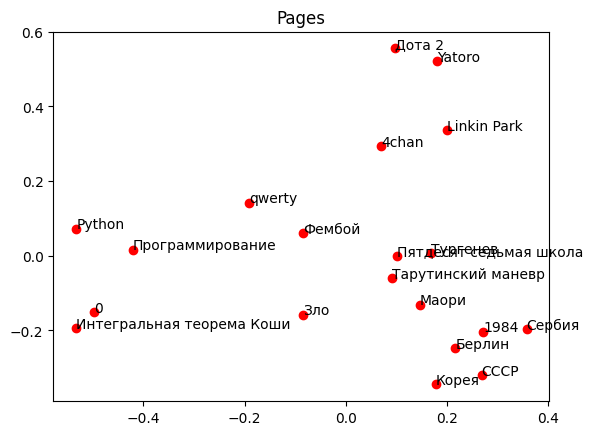

In [231]:
coord = pca.fit_transform(wikis_tfidf)
plt.scatter(coord[:, 0], coord[:, 1], color='red')
plt.title('Pages')

for i, title in enumerate(page_titles):
    plt.annotate(title, xy=(coord[i, 0], coord[i, 1]))
plt.show()

все оч логично, кроме Linkin Park

#4

In [268]:
tfidf_wiki_2 = TfidfVectorizer(analyzer="word",
                               stop_words=stops,
                               ngram_range=(1, 3),
                               min_df=3,
                               token_pattern=r'(?u)\b[^\d\W]+\b')

In [269]:
wikis_tfidf_2 = tfidf_wiki_2.fit_transform(texts)


In [270]:
feature_names = np.array(tfidf_wiki_2.get_feature_names_out())

for i, page in enumerate(texts):
    wiki_vector = wikis_tfidf_2[i, :]
    words = get_top_tf_idf_words(wiki_vector, feature_names, 10)
    print(page_titles[i], '|', words)

Пятдесят седьмая школа | ['школа' 'год' 'учитель' 'здание' 'москва' 'преподаватель' 'м'
 'математический' 'класс' 'кандидат']
Программирование | ['программирование' 'язык' 'язык программирование' 'книга' 'машина'
 'программа' 'машинный' 'китовый' 'код' 'электронный']
Python | ['язык' 'код' 'программирование' 'модуль' 'программа' 'библиотека'
 'функция' 'реализация' 'мочь' 'являться']
1984 | ['выборы' 'министр' 'премьер' 'премьер министр' 'партия' 'погибнуть'
 'парламентский' 'голос' 'ссср' 'президент']
4chan | ['пользователь' 'сайт' 'год' 'интернет' 'который' 'x' 'сообщение'
 'обсуждение' 'the' 'изображение']
СССР | ['ссср' 'год' 'советский' 'республика' 'совет' 'государственный' 'союзный'
 'союз' 'государство' 'орган']
Фембой | ['мужчина' 'термин' 'мочь' 'женщина' 'внешний' 'сообщество' 'контент'
 'сексуальный' 'платформа' 'критика']
Дота 2 | ['игра' 'герой' 'игрок' 'the' 'год' 'матч' 'команда' 'of the' 'of'
 'компания']
Сербия | ['год' 'страна' 'территория' 'являться' 'население' 'км

ура, без цифр!

In [271]:
from sklearn.metrics.pairwise import cosine_similarity

In [319]:
texts_length = len(texts)
texts_sims = {}
for i in range(texts_length):
    sims = {}
    wiki_vector_1 = wikis_tfidf_2[i]
    for j in range(texts_length):
        if i == j:
            continue
        wiki_vector_2 = wikis_tfidf_2[j]
        sims[page_titles[j]] = cosine_similarity(wiki_vector_1, wiki_vector_2)[0][0]
    texts_sims[page_titles[i]] = sorted(sims.items(), key=lambda x: x[1], reverse=True)

In [312]:
texts_sims

{'Пятдесят седьмая школа': [('Сербия', 0.23021435075829816),
  ('Тургенев', 0.21358000392699045),
  ('Маори', 0.15656383887867656),
  ('СССР', 0.1553025785109775),
  ('Yatoro', 0.13585384182003876),
  ('4chan', 0.13060177109743534),
  ('Тарутинский маневр', 0.12187256872158934),
  ('Linkin Park', 0.11874847556102563),
  ('Дота 2', 0.10378272764308293),
  ('Берлин', 0.10236871608131964),
  ('Программирование', 0.08783974827006841),
  ('1984', 0.07972546819261353),
  ('qwerty', 0.07678858889544113),
  ('Python', 0.0722812009498746),
  ('Корея', 0.0687913311785663),
  ('Фембой', 0.06412890209782228),
  ('0', 0.05559108419202451),
  ('Зло', 0.04853950212798838),
  ('Интегральная теорема Коши', 0.008928442269896164)],
 'Программирование': [('Python', 0.5089045632273619),
  ('СССР', 0.1841278949556361),
  ('qwerty', 0.1796375486549907),
  ('Маори', 0.17429725332123044),
  ('Сербия', 0.1698021254168651),
  ('Тургенев', 0.166567272657462),
  ('4chan', 0.12875853142400517),
  ('Linkin Park', 0.

In [323]:
texts_sims_2 = {}
for i in range(texts_length):
    sims = {}
    wiki_vector_1 = wikis_tfidf_2[i]
    for j in range(texts_length):
        wiki_vector_2 = wikis_tfidf_2[j]
        sims[page_titles[j]] = cosine_similarity(wiki_vector_1, wiki_vector_2)[0][0]
    texts_sims_2[page_titles[i]] = sims

In [324]:
texts_sims_2

{'Пятдесят седьмая школа': {'Пятдесят седьмая школа': 1.0000000000000004,
  'Программирование': 0.08783974827006841,
  'Python': 0.0722812009498746,
  '1984': 0.07972546819261353,
  '4chan': 0.13060177109743534,
  'СССР': 0.1553025785109775,
  'Фембой': 0.06412890209782228,
  'Дота 2': 0.10378272764308293,
  'Сербия': 0.23021435075829816,
  'Yatoro': 0.13585384182003876,
  'Интегральная теорема Коши': 0.008928442269896164,
  '0': 0.05559108419202451,
  'qwerty': 0.07678858889544113,
  'Linkin Park': 0.11874847556102563,
  'Корея': 0.0687913311785663,
  'Берлин': 0.10236871608131964,
  'Маори': 0.15656383887867656,
  'Зло': 0.04853950212798838,
  'Тургенев': 0.21358000392699045,
  'Тарутинский маневр': 0.12187256872158934},
 'Программирование': {'Пятдесят седьмая школа': 0.08783974827006841,
  'Программирование': 0.9999999999999996,
  'Python': 0.5089045632273619,
  '1984': 0.08887215806380168,
  '4chan': 0.12875853142400517,
  'СССР': 0.1841278949556361,
  'Фембой': 0.05806781171365127

In [297]:
import seaborn as sns

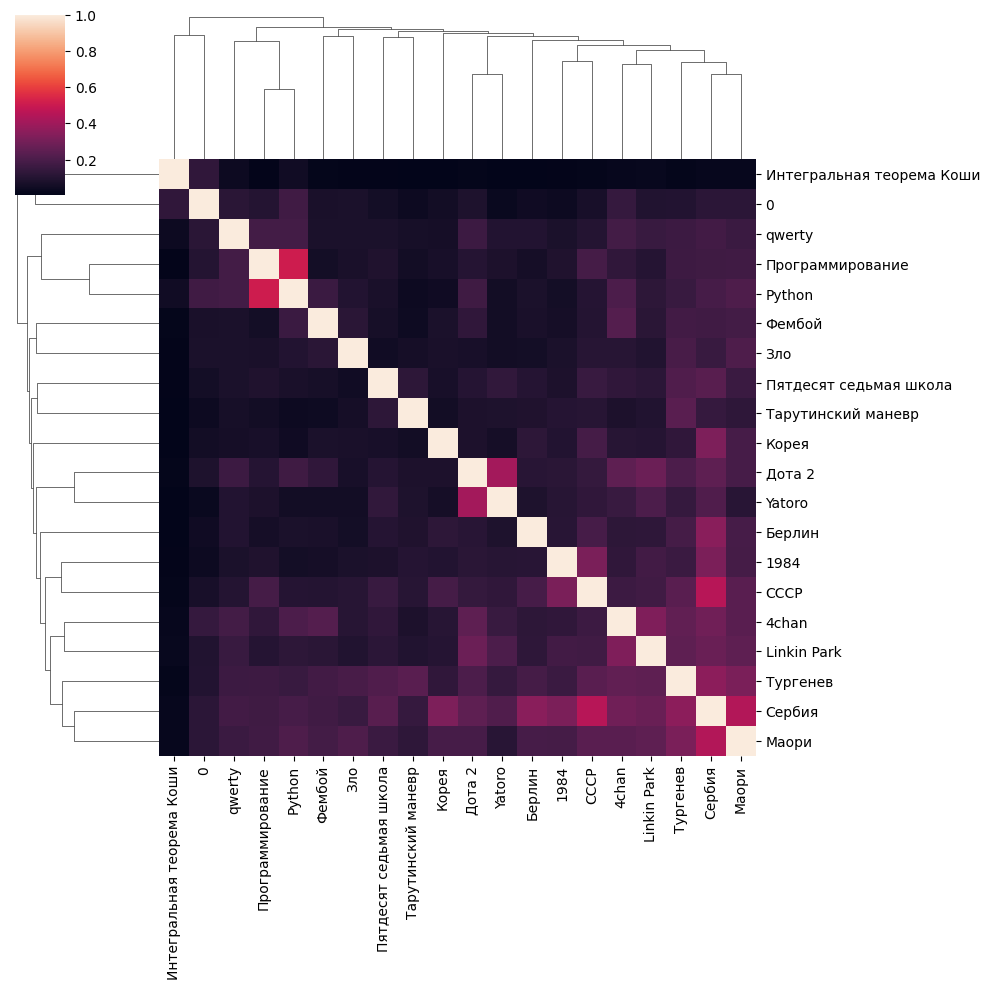

In [325]:
sns.clustermap(texts_sims_2)

In [307]:
iris = sns.load_dataset("iris")
species = iris.pop("species")
iris

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3
